## OpenFace representation

In [2]:
import time
start = time.time()

import argparse
import cv2
import itertools
import os
import numpy as np
np.set_printoptions(precision=2)
import openface
import dlib

In [3]:
# From https://github.com/cmusatyalab/openface/blob/master/demos/compare.py

imgs = [] # input images
dlibFacePredictor = "/home/fien/openface/models/dlib/shape_predictor_68_face_landmarks.dat"
networkModel = "/home/fien/openface/models/openface/nn4.small2.v1.t7"
imgDim = 96
verbose = True

if verbose:
    print("Argument parsing and loading libraries took {} seconds.".format(
        time.time() - start))

start = time.time()
align = openface.AlignDlib(dlibFacePredictor)
net = openface.TorchNeuralNet(networkModel, imgDim)
   
if verbose:
    print("Loading the dlib and OpenFace models took {} seconds.".format(
        time.time() - start))

Argument parsing and loading libraries took 0.627757787704 seconds.
Loading the dlib and OpenFace models took 5.0898668766 seconds.


In [4]:
# This function opens an image, detects and aligns a face.
# Then the face is put through the OpenFace Neural Network to result in a 128-dimensional representation
def getRep(imgPath):
    if verbose:
        print("Processing {}.".format(imgPath))
    bgrImg = cv2.imread(imgPath)
    if bgrImg is None:
        raise Exception("Unable to load image: {}".format(imgPath))
    rgbImg = cv2.cvtColor(bgrImg, cv2.COLOR_BGR2RGB)

    if verbose:
        print("  + Original size: {}".format(rgbImg.shape))

    start = time.time()
    bb = align.getLargestFaceBoundingBox(rgbImg)
    if bb is None:
        raise Exception("Unable to find a face: {}".format(imgPath))
    if verbose:
        print("  + Face detection took {} seconds.".format(time.time() - start))

    start = time.time()
    alignedFace = align.align(imgDim, rgbImg, bb,
                              landmarkIndices=openface.AlignDlib.OUTER_EYES_AND_NOSE)
    if alignedFace is None:
        raise Exception("Unable to align image: {}".format(imgPath))
    if verbose:
        print("  + Face alignment took {} seconds.".format(time.time() - start))

    start = time.time()
    rep = net.forward(alignedFace) 
    
    if verbose:
        print("  + OpenFace forward pass took {} seconds.".format(time.time() - start))
        print("Representation:")
        print(rep)
        print("-----\n")
    return rep

## Comparison of 2 random faces

In [5]:
img1 = "faces/women/woman1.jpg"
img2 = "faces/women/woman2.jpg"

d = getRep(img1) - getRep(img2)
print("Comparing {} with {}.".format(img1, img2))
print("  + Squared l2 distance between representations: {:0.3f}".format(np.dot(d, d)))

Processing faces/women/woman1.jpg.
  + Original size: (512, 512, 3)
  + Face detection took 0.773123025894 seconds.
  + Face alignment took 0.0378291606903 seconds.
  + OpenFace forward pass took 0.149989128113 seconds.
Representation:
[ 0.07 -0.11  0.04  0.   -0.02  0.03 -0.    0.06 -0.02 -0.12  0.1   0.1
  0.07 -0.08 -0.07  0.08 -0.19 -0.13 -0.19  0.17  0.07 -0.03  0.08 -0.05
 -0.12  0.06  0.03 -0.04 -0.07 -0.06 -0.1   0.08  0.02  0.18 -0.16  0.02
 -0.04  0.09 -0.06  0.07  0.05 -0.16 -0.02 -0.04 -0.04 -0.08  0.02 -0.03
 -0.07  0.2  -0.02 -0.06 -0.16  0.16  0.1  -0.08 -0.03 -0.04 -0.11  0.1
 -0.04 -0.04  0.06  0.03  0.02 -0.01 -0.05  0.03 -0.01  0.03 -0.09 -0.03
 -0.    0.15  0.11 -0.03  0.11 -0.04 -0.05  0.1   0.07 -0.19  0.03 -0.02
 -0.14  0.13  0.09  0.03 -0.02  0.08  0.11 -0.15 -0.1   0.09 -0.12  0.07
 -0.08 -0.03  0.08  0.02 -0.01 -0.06 -0.08  0.07  0.15  0.04 -0.06  0.2
 -0.04 -0.15 -0.12  0.13 -0.02  0.01  0.06  0.03  0.1   0.08  0.06  0.16
  0.02  0.03  0.08  0.08  0.05  0.01 

## Dimension reduction

In [6]:
verbose = False

In [7]:
# load data
women = [] 
women_directory = "/home/fien/Documents/thesis/face-classification/faces/women"

for image in os.listdir(women_directory):
    women.append(getRep(women_directory + "/" + image).tolist())
    
print(np.array(women).shape)

women_labels = np.zeros(20)
print(women_labels.shape)

    
men = [] 
men_directory = "/home/fien/Documents/thesis/face-classification/faces/men"

for image in os.listdir(men_directory):
    men.append(getRep(men_directory + "/" + image).tolist())
    
print(np.array(men).shape)

men_labels = np.ones(20)
print(men_labels.shape)

(20, 128)
(20,)
(20, 128)
(20,)


In [8]:
data = women + men 
labels = women_labels.tolist() + men_labels.tolist()
print(np.array(data).shape)
print(np.array(labels).shape)

(40, 128)
(40,)


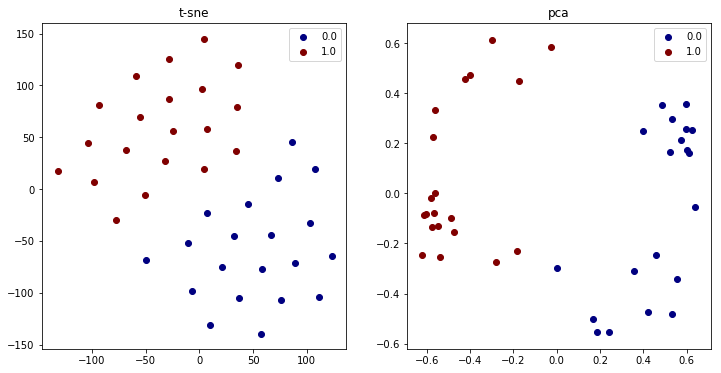

In [23]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot([1,2])

# visualize data in tnse (men/women)
X_embedded_tsne = TSNE(n_components=2, init='pca').fit_transform(data)

plt.subplot(121)
unique = list(set(labels))
colors = [plt.cm.jet(float(i)/max(unique)) for i in unique]
for i, u in enumerate(unique):
    xi = [X_embedded_tsne[j, 0] for j  in range(len(X_embedded_tsne[:,0])) if labels[j] == u]
    yi = [X_embedded_tsne[j, 1] for j  in range(len(X_embedded_tsne[:,1])) if labels[j] == u]
    plt.scatter(xi, yi, c=colors[i], label=str(u))
plt.legend()
plt.title("t-sne")

# visualize data in pca (men/women)
X_embedded_pca = PCA(n_components=2).fit_transform(data)

plt.subplot(122)
unique = list(set(labels))
colors = [plt.cm.jet(float(i)/max(unique)) for i in unique]
for i, u in enumerate(unique):
    xi = [X_embedded_pca[j, 0] for j  in range(len(X_embedded_pca[:,0])) if labels[j] == u]
    yi = [X_embedded_pca[j, 1] for j  in range(len(X_embedded_pca[:,1])) if labels[j] == u]
    plt.scatter(xi, yi, c=colors[i], label=str(u))
plt.legend()
plt.title("pca")

plt.show()

## k-NN classifier

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.8, random_state=42)

In [21]:
print(np.array(X_train).shape)

(8, 128)


In [22]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.96875

In [24]:
X_train_tsne, X_test_tsne, y_train_tsne, y_test_tsne = train_test_split(X_embedded_tsne, labels, test_size=0.8, random_state=42)

knn_tsne = KNeighborsClassifier(n_neighbors=3)
knn_tsne.fit(X_train_tsne, y_train_tsne)
knn_tsne.score(X_test_tsne, y_test_tsne)

0.9375